**GOALS**:
- compute with a non-distributed methods the features from mobilenetV2 and the PCA projection.
- assess time.
- compare values with the results found with the spark method.

**Table of contents**<a id='toc0_'></a>    
- 1. [Local methods with tf](#toc1_)    
- 2. [Comparing image values after both ways to load it.](#toc2_)    
  - 2.1. [tf loading](#toc2_1_)    
  - 2.2. [Pyspark / pillow loading](#toc2_2_)    
  - 2.3. [Comparison](#toc2_3_)    
- 3. [Check online_results](#toc3_)    
  - 3.1. [Values](#toc3_1_)    
  - 3.2. [ t-SNE Plots](#toc3_2_)    
    - 3.2.1. [On the raw features computed with spark in EMR](#toc3_2_1_)    
    - 3.2.2. [On the pca_features computed with spark in the EMR](#toc3_2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Local methods with tf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import shutil
import random
from glob import glob

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

2023-07-24 14:52:31.281390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 14:52:31.755946: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 14:52:31.758274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 14:52:33.440226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_DIR = os.path.join(os.getcwd(), 'images_subset')
print(IMAGE_DIR)

/home/louberehc/OCR/projets/8_cloud_computing/images_subset


In [3]:
im_paths = glob(IMAGE_DIR +'/*/*')

In [4]:
def load_image_and_get_label(imagePath):
	# read the image from disk, decode it, convert the data type to
	# floating point, resize it, and pre-process for MobileNet
	image = tf.io.read_file(imagePath)
	image = tf.io.decode_jpeg(image, channels=3)
	# image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, (224,224))
	image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
 
	# get class label from the file path and convert to categorical vector
	label = tf.strings.split(imagePath, os.path.sep)[-2]
 
	return (image, label)

In [13]:
BATCH_SIZE = 16

ds = (
    tf.data.Dataset.from_tensor_slices(im_paths)
    .map(load_image_and_get_label, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    # .prefecth(tf.data.AUTOTUNE)
)

2023-07-19 14:16:58.216589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [320]
	 [[{{node Placeholder/_0}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers

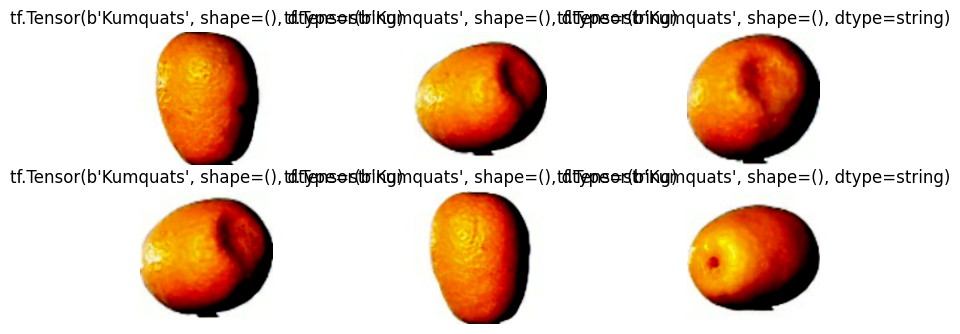

In [14]:
# Visualize first items of the training dataset
plt.figure(figsize=(10, 10))
for images, labels in ds.take(1):
  for i in range(6):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")

In [15]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))
    
for layer in model.layers:
    layer.trainable = False
        
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [16]:
res = new_model.predict(ds)
type(res)

2023-07-19 14:17:01.267207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [320]
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 8s 374ms/step


numpy.ndarray

It took only ~8 s

In [20]:
res.shape

(320, 1280)

In [21]:
len(im_paths)

320

In [26]:
res_df = pd.DataFrame(
    res,
    index=im_paths,
).rename(columns=(lambda n: f'feature{n}'))

In [27]:
res_df.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature1270,feature1271,feature1272,feature1273,feature1274,feature1275,feature1276,feature1277,feature1278,feature1279
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg,0.036694,0.0,0.0,0.0,0.005719,0.028472,0.058900,0.028014,0.000000,0.000000,...,0.000000,0.0,0.000000,0.003670,0.038330,0.000000,0.0,0.0,0.034528,0.0
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_214_100.jpg,0.309548,0.0,0.0,0.0,0.000009,0.000000,1.155231,0.000000,0.145102,0.039393,...,0.064710,0.0,0.000000,0.030180,0.043894,0.088751,0.0,0.0,0.004618,0.0
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_234_100.jpg,0.092173,0.0,0.0,0.0,0.000000,0.000000,0.620752,0.016290,0.022272,0.025216,...,0.000000,0.0,0.000000,0.000000,0.184897,0.013192,0.0,0.0,0.000000,0.0
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_219_100.jpg,0.327651,0.0,0.0,0.0,0.014103,0.000000,0.602290,0.000000,0.078213,0.032840,...,0.138702,0.0,0.000000,0.191602,0.023143,0.006719,0.0,0.0,0.000000,0.0
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/21_100.jpg,0.294717,0.0,0.0,0.0,0.023944,0.012229,0.219464,0.019068,0.000000,0.000000,...,0.023362,0.0,0.005253,0.047513,0.179043,0.000000,0.0,0.0,0.134759,0.0


In [24]:
res_df.loc['/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Granadilla/269_100.jpg']

0       0.826699
1       0.033531
2       0.000000
3       0.000000
4       0.000000
          ...   
1275    0.000000
1276    0.000000
1277    0.000000
1278    0.232679
1279    0.000000
Name: /home/louberehc/OCR/projets/8_cloud_computing/images_subset/Granadilla/269_100.jpg, Length: 1280, dtype: float32

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [28]:
scaler = StandardScaler()
Xs = scaler.fit_transform(res)

Xs_df = pd.DataFrame(
    Xs,
    index=im_paths,
).rename(columns=(lambda n: f'scaled{n}'))


In [29]:
Xs.shape

(320, 1280)

In [32]:
Xs_df.head()

,scaled0,scaled1,scaled2,scaled3,scaled4,scaled5,scaled6,scaled7,scaled8,scaled9,...,scaled1270,scaled1271,scaled1272,scaled1273,scaled1274,scaled1275,scaled1276,scaled1277,scaled1278,scaled1279
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg,-0.657496,-0.346757,-0.316188,-0.217435,-0.492610,-0.477053,-0.989384,-0.389851,-0.594828,-0.385387,...,-0.478175,-0.209252,-0.575789,-0.598875,-0.467085,-0.485304,-0.234427,-0.350481,-0.374162,-0.505272
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_214_100.jpg,-0.095663,-0.346757,-0.316188,-0.217435,-0.502856,-0.526300,0.675114,-0.510211,-0.078032,-0.202470,...,-0.276462,-0.209252,-0.575789,-0.549170,-0.455207,0.159599,-0.234427,-0.350481,-0.510701,-0.505272
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_234_100.jpg,-0.543261,-0.346757,-0.316188,-0.217435,-0.502873,-0.526300,-0.136356,-0.440222,-0.515503,-0.268301,...,-0.478175,-0.209252,-0.575789,-0.605756,-0.154196,-0.389444,-0.234427,-0.350481,-0.531784,-0.505272
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_219_100.jpg,-0.058388,-0.346757,-0.316188,-0.217435,-0.477567,-0.526300,-0.164385,-0.510211,-0.316263,-0.232902,...,-0.045816,-0.209252,-0.575789,-0.246505,-0.499507,-0.436483,-0.234427,-0.350481,-0.531784,-0.505272
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/21_100.jpg,-0.126202,-0.346757,-0.316188,-0.217435,-0.459908,-0.505148,-0.745609,-0.428286,-0.594828,-0.385387,...,-0.405352,-0.209252,-0.553027,-0.516671,-0.166694,-0.485304,-0.234427,-0.350481,0.083392,-0.505272


In [36]:
Xs_df.iloc[:,:10].describe().loc[['mean', 'std'],:]

,scaled0,scaled1,scaled2,scaled3,scaled4,scaled5,scaled6,scaled7,scaled8,scaled9
mean,0.000000,1.192093e-08,-3.576279e-08,5.960465e-09,0.000000,0.000000,0.000000,4.470349e-09,-1.192093e-08,2.980232e-09
std,1.001566,1.001566e+00,1.001566e+00,1.001566e+00,1.001566,1.001566,1.001566,1.001566e+00,1.001566e+00,1.001566e+00


In [31]:
pca = PCA(n_components=300)
pca_proj_df = pd.DataFrame(
    pca.fit_transform(Xs),
    index=im_paths,
).rename(columns=(lambda n: f'pc{n}'))

In [33]:
pca_proj_df.head()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc290,pc291,pc292,pc293,pc294,pc295,pc296,pc297,pc298,pc299
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg,-10.007625,-7.017603,1.801875,0.416930,-1.953220,-1.943839,5.272502,0.503746,2.458562,2.338848,...,1.207410,-0.716957,-0.186119,-1.040322,0.490834,-1.283825,-0.700579,-0.916007,0.570164,-0.235834
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_214_100.jpg,-12.614198,-3.223257,5.702065,-2.864845,-0.591549,1.219161,2.128430,-2.323347,-1.357752,2.458856,...,-0.556702,0.343236,-0.867447,0.009281,-0.255725,0.752391,-0.704942,0.211913,-0.126160,0.543293
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_234_100.jpg,-12.921830,-3.229964,4.742172,-2.232263,-1.883105,0.878375,1.476774,-1.863286,-1.009567,2.581735,...,0.115998,-0.435327,1.761467,0.345832,0.463663,-0.116244,1.257489,-0.424948,-0.068353,-0.218507
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/r_219_100.jpg,-12.698199,-3.335060,4.555241,-2.185730,-0.450105,1.373521,1.046035,-2.524190,-0.986018,0.977297,...,-0.082534,0.699236,-1.278469,-0.271649,-0.540414,0.573854,-0.472436,0.433877,0.700375,-0.278811
/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/21_100.jpg,-10.725255,-5.999208,3.257338,-0.220126,-1.996289,0.073442,7.230210,-0.810116,3.291776,2.635499,...,-0.769167,0.357411,-0.932596,0.615322,-1.283860,0.232016,1.043379,-1.221794,-0.417285,0.624403


scale and compute PCA took ~ half a second. Thus less than 9 seconds to compute results from 320 images.

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Comparing image values after both ways to load it.

## 2.1.  [&#9650;](#toc0_) <a id='toc2_1_'></a>tf loading

In [38]:
im_path_ = im_paths[0]
im_path_

'/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg'

In [53]:
for images, labels in ds.take(1):
    image_tf = images[0, :, :, :].numpy()
    break

2023-07-18 18:23:52.262796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [320]
	 [[{{node Placeholder/_0}}]]


In [54]:
image_tf.shape

(224, 224, 3)

## 2.2.  [&#9650;](#toc0_) <a id='toc2_2_'></a>Pyspark / pillow loading


In [95]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, element_at, split
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml import Pipeline

from typing import Iterator

from PIL import Image
import io

PATH = os.getcwd()
DATA_PATH = os.path.join(PATH ,'fruits_360')
RESULT_PATH = os.path.join(PATH ,'Results')
TRAIN_PATH = os.path.join(DATA_PATH , 'Training')
TEST_PATH = os.path.join(DATA_PATH , 'Test')
IMAGE_SUBSET_PATH = os.path.join(PATH, 'images_subset')


In [58]:
spark = (
    SparkSession
    .builder
    .appName('P8')
    .master('local[*]')
    .config("spark.sql.parquet.writeLegacyFormat", 'true')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/18 18:25:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [59]:
sc = spark.sparkContext

In [60]:
spark

In [77]:
# Load Images
images = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(IMAGE_SUBSET_PATH)
    
# Add a label column from the image path
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

In [78]:
images

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary, label: string]

In [79]:
def preprocess(content):
    """
    - Takes raw image bytes and transforms it to a pillow image.
    - Resize the images to the Mobilenet input size 
    and preprocess the pixel values.    
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


In [106]:
(
    images
    .where('path == "file:/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg"')
    .count()
)

1

In [107]:
content_ = (
    images
    .where('path == "file:/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg"')
    .collect()[0]['content']
)

In [108]:
content_

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00d\x00d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\

In [109]:
image_pyspark = preprocess(content_)

In [110]:
image_pyspark.shape

(224, 224, 3)

## 2.3.  [&#9650;](#toc0_) <a id='toc2_3_'></a>Comparison

In [111]:
type(image_pyspark)

numpy.ndarray

In [100]:
type(image_tf)

numpy.ndarray

In [101]:
np.array_equal(image_pyspark, image_tf)

False

In [103]:
image_pyspark.min()

-0.81960785

In [104]:
image_tf.min()

-0.78977597

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


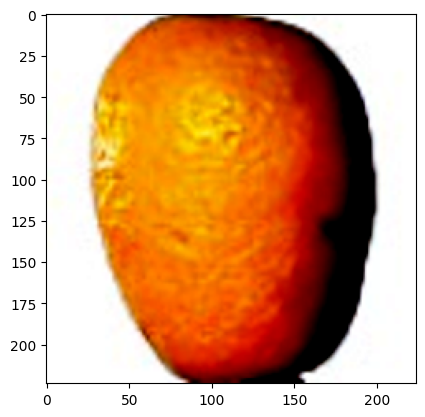

In [112]:
plt.imshow(image_pyspark)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


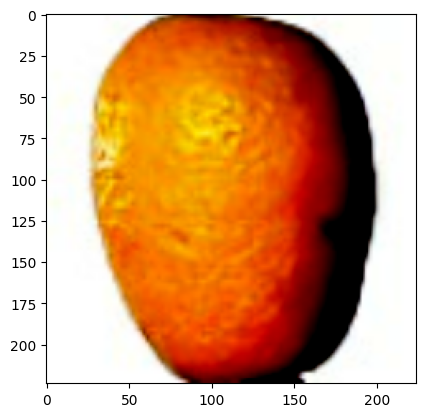

In [113]:
plt.imshow(image_tf)
plt.show()

Visually, it is almost the same.

In details, values are a bit different.

The tf.resize and Image.resize function have different resampling methods (BICUBIC/BILINEAR).

Thus, I can not compare features values with the ones computed in the first section except if I change the resampling methods in the *preprocess* function?

In [127]:
def preprocess(content):
    """
    - Takes raw image bytes and transforms it to a pillow image.
    - Resize the images to the Mobilenet input size 
    and preprocess the pixel values.    
    """
    img = (
        Image
        .open(io.BytesIO(content))
        .resize([224, 224], resample=Image.Resampling.BILINEAR)
    )
    arr = img_to_array(img)
    return preprocess_input(arr)

In [128]:
image_pyspark = preprocess(content_)

In [129]:
image_pyspark.min()

-0.7647059

Still a difference...
Let's try to do the exact same pre-processing with tf in the spark environment.

In [131]:
def preprocess2(im_path):
    # read the image from disk, decode it, convert the data type to
    # floating point, resize it, and pre-process for MobileNetV2
    image = tf.io.read_file(im_path)
    image = tf.io.decode_jpeg(image, channels=3)
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (224,224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

In [137]:
image_3 = preprocess2("/home/louberehc/OCR/projets/8_cloud_computing/images_subset/Kumquats/71_100.jpg").numpy()

In [138]:
image_3.min()

-0.78977597

In [139]:
image_tf.min()

-0.78977597

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Check online_results

## 3.1.  [&#9650;](#toc0_) <a id='toc3_1_'></a>Values

In [2]:
df = pd.read_parquet('./online_results', engine='pyarrow')
df.shape

(320, 4)

In [3]:
df.head()

,path,label,features,pca_features
0,s3://oc-cloud-computing/images_subset/Raspberr...,Raspberry,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
1,s3://oc-cloud-computing/images_subset/Cucumber...,Cucumber Ripe,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
2,s3://oc-cloud-computing/images_subset/Raspberr...,Raspberry,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
3,s3://oc-cloud-computing/images_subset/Rambutan...,Rambutan,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."
4,s3://oc-cloud-computing/images_subset/Guava/r_...,Guava,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va..."


In [4]:
item = df.loc[0, :]

In [40]:
item

path            s3://oc-cloud-computing/images_subset/Raspberr...
label                                                   Raspberry
features        {'type': 1, 'size': None, 'indices': None, 'va...
pca_features    {'type': 1, 'size': None, 'indices': None, 'va...
Name: 0, dtype: object

In [5]:
item.path

's3://oc-cloud-computing/images_subset/Raspberry/278_100.jpg'

In [6]:
item.features['values']

array([0.01330895, 0.32459942, 0.16440053, ..., 0.00497751, 0.19330928,
       0.03508363])

In [7]:
item.features['values'].shape

(1280,)

In [8]:
item.pca_features['values'].shape

(300,)

## 3.2.  [&#9650;](#toc0_) <a id='toc3_2_'></a> t-SNE Plots

### 3.2.1.  [&#9650;](#toc0_) <a id='toc3_2_1_'></a>On the raw features computed with spark in EMR

In [9]:
from sklearn.manifold import TSNE

In [36]:
def display_2d_projection_with_illustrative_var(
    X,
    ax=None,
    figsize=(7,7),
    illustrative_var=None,
    alpha=0.7,
    palette=None,
    title=None,
):
    """ 
    Display the 2D projection with color for each class of 
    illustrative var.

    X : result of transform (pca, tsne, lda...)
    illustrative_var : list of length len(X) containing classes.
    """
    # Boolean which automates plt.show() if no ax is provided.
    final_plot = False
    if ax is None:
        fig, ax= plt.subplots(figsize=figsize)
        final_plot = True

    # Display the points
    if illustrative_var is None:
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=alpha)
    else:
        illustrative_var = np.array(illustrative_var)
        illustrative_values = np.unique(illustrative_var)
        n_val = len(illustrative_values)
        if palette is None:
            palette = sns.color_palette(cc.glasbey, n_val)
        # Plot reversely to see most frequent on top.
        for n, value in enumerate(illustrative_values):
            selected = np.where(illustrative_var == value)
            ax.scatter(
                X[selected, 0], X[selected, 1],
                alpha=alpha, label=value, color=palette[n_val - 1 - n],
                s=10
            )
        ax.set_axis_off()
        if title is not None:
            ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1),
                    loc='upper left',
                    borderaxespad=0.,
                    fontsize=10)
        
        if final_plot:
            plt.show()
    return None


In [11]:
df.label.unique()

array(['Raspberry', 'Cucumber Ripe', 'Rambutan', 'Guava', 'Apple Red 1',
       'Pitahaya Red', 'Granadilla', 'Pepper Red', 'Peach', 'Kiwi',
       'Lemon Meyer', 'Nut Forest', 'Pear Kaiser', 'Kumquats', 'Maracuja',
       'Apple Pink Lady', 'Potato White', 'Onion White', 'Tamarillo',
       'Apple Golden 2', 'Cherry Wax Red', 'Pear Red', 'Huckleberry',
       'Tomato not Ripened', 'Pomelo Sweetie', 'Grape White 3',
       'Grape White 4', 'Strawberry Wedge', 'Tomato 2',
       'Grapefruit White', 'Cherry 1', 'Dates'], dtype=object)

In [13]:
class_selection = [
    'Raspberry',
    'Cucumber Ripe',
    'Rambutan',
    'Guava',
    'Apple Red 1',
    'Pitahaya Red',
    'Granadilla',
    'Pepper Red',
    'Peach',
    'Kiwi',
]

len(class_selection)

10

In [14]:
sel_df = df.query('label in @class_selection')
sel_df.shape

(100, 4)

In [28]:
# Extract the features values of the 100 images into a matrix
fts = np.vstack(
    [sel_df.iloc[k, :].features['values'] for k in range(len(sel_df))]
)
fts.shape

(100, 1280)

In [30]:
# Get associated labels
labels = sel_df.label
labels.shape

(100,)

In [33]:
X_tsne = TSNE(n_components=2, perplexity=30).fit_transform(fts)

In [37]:
import colorcet as cc
import seaborn as sns

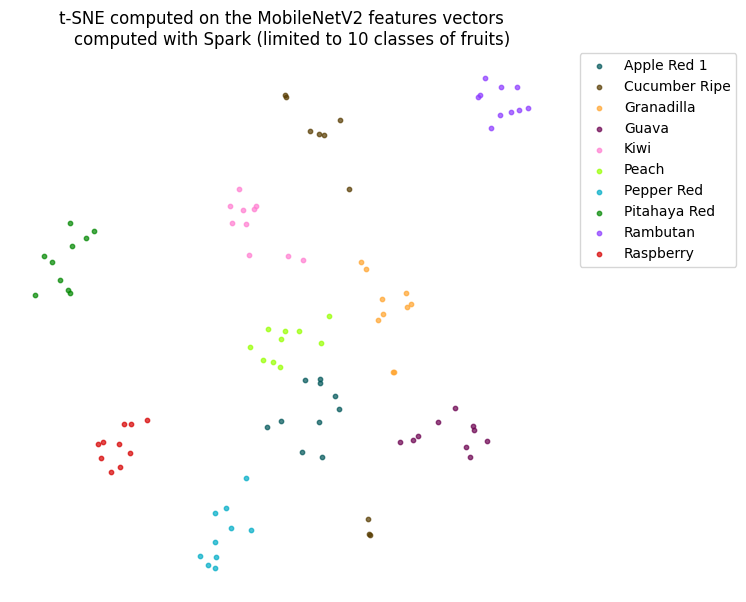

In [39]:
n_val = 10

display_2d_projection_with_illustrative_var(
    X=X_tsne,
    illustrative_var=labels,
    palette=sns.color_palette(cc.glasbey, n_val),
    title='''t-SNE computed on the MobileNetV2 features vectors
    computed with Spark (limited to 10 classes of fruits)'''
)

### 3.2.2.  [&#9650;](#toc0_) <a id='toc3_2_2_'></a>On the pca_features computed with spark in the EMR

In [43]:
pca_fts = np.vstack(
    [sel_df.iloc[k, :].pca_features['values'] for k in range(len(sel_df))]
)
pca_fts.shape

(100, 300)

In [44]:
X_pca_tsne = TSNE(n_components=2, perplexity=30).fit_transform(pca_fts)

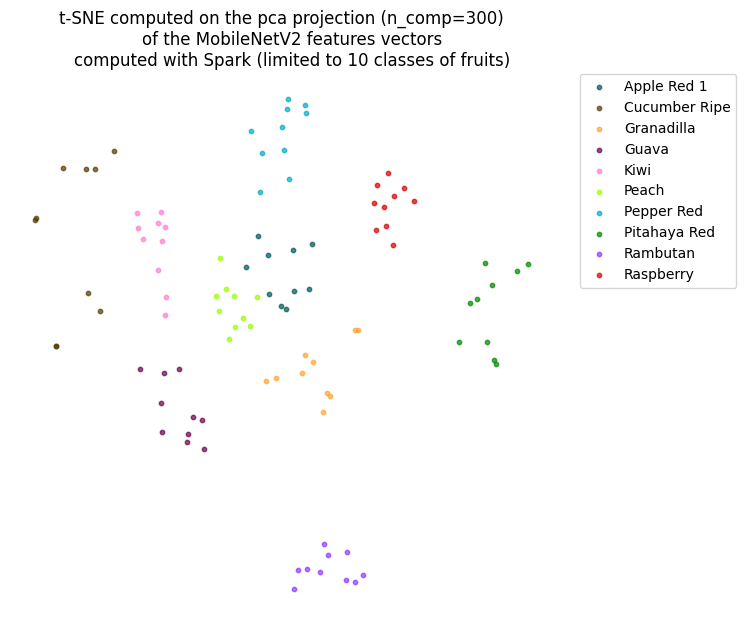

In [46]:
n_val = 10

display_2d_projection_with_illustrative_var(
    X=X_pca_tsne,
    illustrative_var=labels,
    palette=sns.color_palette(cc.glasbey, n_val),
    title='''t-SNE computed on the pca projection (n_comp=300)
    of the MobileNetV2 features vectors
    computed with Spark (limited to 10 classes of fruits)'''
)